In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# Chargement des données

In [2]:
data_train = pd.read_csv('airbnb_train.csv')

# Première analyse des données

In [3]:
print("shape : ", data_train.shape)
print(data_train.info())

shape :  (22234, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_ver

In [4]:
data_train.head(2)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0


# Preprocessing

## Doublons

In [5]:
doublons = data_train[data_train.duplicated(keep=False)]
print(f"Nombre de lignes dupliquées : {doublons.shape[0]}")
print(doublons)

Nombre de lignes dupliquées : 0
Empty DataFrame
Columns: [id, log_price, property_type, room_type, amenities, accommodates, bathrooms, bed_type, cancellation_policy, cleaning_fee, city, description, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, instant_bookable, last_review, latitude, longitude, name, neighbourhood, number_of_reviews, review_scores_rating, zipcode, bedrooms, beds]
Index: []

[0 rows x 28 columns]


Pas de doublons, on passe à la suite

## Valeurs manquantes

In [6]:
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

bathrooms                   51
first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
last_review               4716
neighbourhood             2086
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64


Corrigeons ces valeurs manquantes dans l'ordre :

- bathrooms  
Imputation par la médiane (plus robuste que la moyenne).

In [7]:
data_train['bathrooms'].fillna(data_train['bathrooms'].median(), inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
last_review               4716
neighbourhood             2086
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64


<ipython-input-7-368bb7692dc9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['bathrooms'].fillna(data_train['bathrooms'].median(), inplace=True)


- first review / last_review  
Transformer en datetime, créer une variable has_review = 1 si la date existe, sinon 0, imputer avec une valeur arbitraire (ex. très ancienne)

In [8]:
data_train['first_review'] = pd.to_datetime(data_train['first_review'])
data_train['last_review'] = pd.to_datetime(data_train['last_review'])
data_train['has_first_review'] = data_train['first_review'].notnull().astype(int)
data_train['has_last_review'] = data_train['last_review'].notnull().astype(int)
data_train.drop(columns=['first_review', 'last_review'], inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
neighbourhood             2086
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64


- host_has_profile_pic / host_identity_verified  
Ces champs sont booléens, donc imputation par la modalité la plus fréquente

In [9]:
for col in ['host_has_profile_pic', 'host_identity_verified']:
    mode_val = data_train[col].mode()[0]
    data_train[col].fillna(mode_val, inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

host_response_rate      5475
host_since                56
neighbourhood           2086
review_scores_rating    4978
zipcode                  303
bedrooms                  26
beds                      35
dtype: int64


<ipython-input-9-b07853711dba>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train[col].fillna(mode_val, inplace=True)


- host_response_rateNettoyer   
enlever le %, convertir en float, puis imputer par la médiane

In [10]:
data_train['host_response_rate'] = data_train['host_response_rate'].str.rstrip('%').astype(float)
data_train['host_response_rate'].fillna(data_train['host_response_rate'].median(), inplace=True)

missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

host_since                56
neighbourhood           2086
review_scores_rating    4978
zipcode                  303
bedrooms                  26
beds                      35
dtype: int64


<ipython-input-10-4e6e14c88d64>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['host_response_rate'].fillna(data_train['host_response_rate'].median(), inplace=True)


- host_since  
Convertir en date, calculer une feature comme host_years_active = current_date - host_since, imputer avec la date la plus fréquente

In [11]:
data_train['host_since'] = pd.to_datetime(data_train['host_since'])
data_train['host_years_active'] = (pd.to_datetime('today') - data_train['host_since']).dt.days // 365
data_train['host_years_active'].fillna(data_train['host_years_active'].median(), inplace=True)
data_train.drop(columns=['host_since'], inplace=True)

missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

neighbourhood           2086
review_scores_rating    4978
zipcode                  303
bedrooms                  26
beds                      35
dtype: int64


<ipython-input-11-31d30f81fbbf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['host_years_active'].fillna(data_train['host_years_active'].median(), inplace=True)


- neighbourhood

In [12]:
data_train['neighbourhood'].fillna('unknown', inplace=True)

missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

<ipython-input-12-df30ad513a90>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['neighbourhood'].fillna('unknown', inplace=True)


review_scores_rating    4978
zipcode                  303
bedrooms                  26
beds                      35
dtype: int64


- review_scores_rating   
créer has_review_score, imputer par la médiane

In [13]:
data_train['review_scores_rating'].fillna(data_train['review_scores_rating'].median(), inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

zipcode     303
bedrooms     26
beds         35
dtype: int64


<ipython-input-13-adfc1245beab>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['review_scores_rating'].fillna(data_train['review_scores_rating'].median(), inplace=True)


- zipcode   
imputer par unkown

In [14]:
data_train['zipcode'].fillna('unknown', inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

bedrooms    26
beds        35
dtype: int64


<ipython-input-14-afa1747eb7a9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['zipcode'].fillna('unknown', inplace=True)


- bedrooms / beds   
Imputation par la médiane

In [15]:
data_train['bedrooms'].fillna(data_train['bedrooms'].median(), inplace=True)
data_train['beds'].fillna(data_train['beds'].median(), inplace=True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

Series([], dtype: int64)


<ipython-input-15-9b8693109886>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['bedrooms'].fillna(data_train['bedrooms'].median(), inplace=True)
<ipython-input-15-9b8693109886>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [16]:
data_train.drop(columns=['cleaning_fee'], inplace = True)
missing_per_col = data_train.isnull().sum()
missing_with_values = missing_per_col[missing_per_col > 0]

print(missing_with_values)

Series([], dtype: int64)


Plus de valeurs manquantes, on passe à la suite

## Labellisation des variables non-numériques

In [17]:
non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index(['property_type', 'room_type', 'amenities', 'bed_type',
       'cancellation_policy', 'city', 'description', 'host_has_profile_pic',
       'host_identity_verified', 'instant_bookable', 'name', 'neighbourhood',
       'zipcode'],
      dtype='object')


In [18]:
data_train = pd.get_dummies(data_train, columns=['room_type', 'bed_type'], drop_first=True)
non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index(['property_type', 'amenities', 'cancellation_policy', 'city',
       'description', 'host_has_profile_pic', 'host_identity_verified',
       'instant_bookable', 'name', 'neighbourhood', 'zipcode',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed'],
      dtype='object')


In [19]:
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    data_train[col] = data_train[col].map({'t': 1, 'f': 0})

non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index(['property_type', 'amenities', 'cancellation_policy', 'city',
       'description', 'name', 'neighbourhood', 'zipcode',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed'],
      dtype='object')


In [20]:
data_train['desc_length'] = data_train['description'].fillna('').apply(len)
data_train['name_length'] = data_train['name'].fillna('').apply(len)
data_train.drop(columns=['description', 'name'], inplace=True)  # sauf si NLP prévu

non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index(['property_type', 'amenities', 'cancellation_policy', 'city',
       'neighbourhood', 'zipcode', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed'],
      dtype='object')


In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
cat_cols = ['property_type','city','neighbourhood','zipcode','room_type_Private room','room_type_Shared room','bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed']
for col in cat_cols:
    le = LabelEncoder()
    data_train[col] = data_train[col].astype(str).fillna("Missing")  # conversion explicite en str
    data_train[col] = le.fit_transform(data_train[col])

non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index(['amenities', 'cancellation_policy'], dtype='object')


In [23]:
data_train.drop(columns=['amenities', 'cancellation_policy'], inplace=True) # On enlève pour le moment

In [24]:
non_numeric_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index([], dtype='object')


## Correlations

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

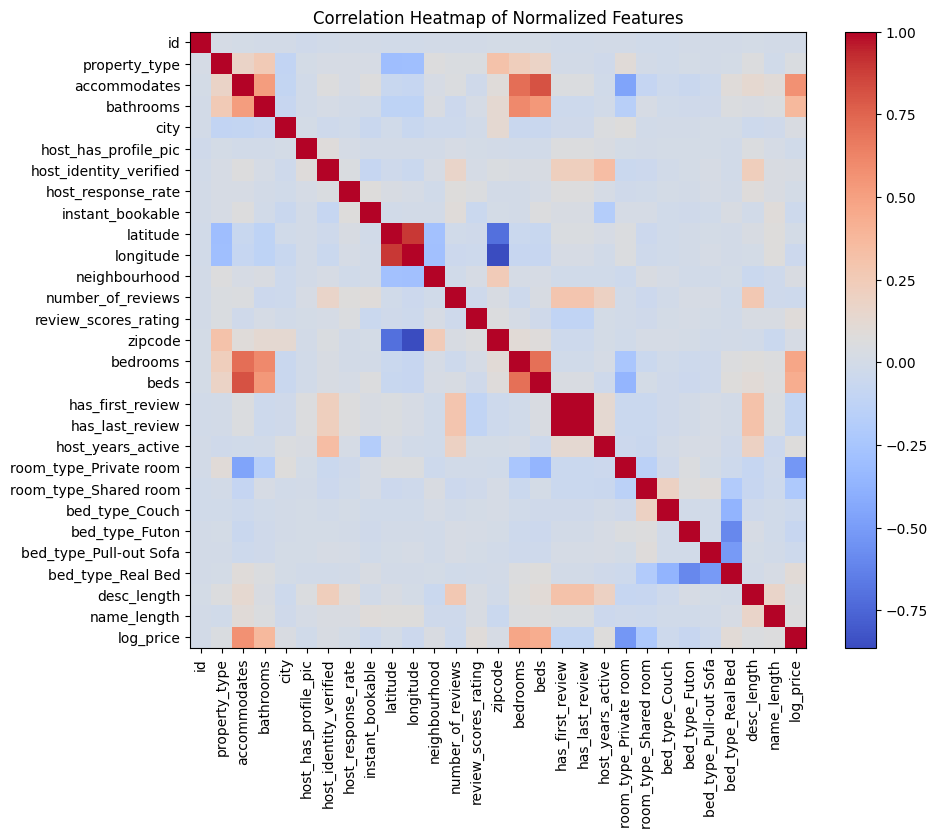

In [26]:
target_col = 'log_price'

numerical_columns = data_train.select_dtypes(include=['int64', 'float64']).drop(columns=[target_col])
scaler = StandardScaler()
numerical_columns_scaled = scaler.fit_transform(numerical_columns)
data_train_scaled = pd.DataFrame(numerical_columns_scaled, columns=numerical_columns.columns, index=data_train.index)
data_train_scaled[target_col] = data_train[target_col]
correlations = data_train_scaled.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlations)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations)), correlations.columns)
plt.title('Correlation Heatmap of Normalized Features')
plt.show()

In [27]:
corr_matrix = correlations
corr_with_target = corr_matrix['log_price'].drop('log_price')
top = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index).head(500)
top_df = top.reset_index()
top_df.columns = ['feature', 'corr_with_results_x']
print(top_df)

                   feature  corr_with_results_x
0             accommodates             0.564874
1   room_type_Private room            -0.526310
2                 bedrooms             0.472728
3                     beds             0.435068
4                bathrooms             0.368856
5    room_type_Shared room            -0.221407
6        bed_type_Real Bed             0.102379
7         has_first_review            -0.096202
8          has_last_review            -0.095994
9     review_scores_rating             0.085310
10          bed_type_Futon            -0.070902
11       host_years_active             0.069754
12             name_length             0.063846
13             desc_length             0.047935
14               longitude            -0.045348
15           property_type             0.042389
16        instant_bookable            -0.040482
17       number_of_reviews            -0.039138
18          bed_type_Couch            -0.038468
19           neighbourhood             0

In [28]:
significant_corr = top_df[top_df['corr_with_results_x'].abs() > 0.1]

print(significant_corr)

                  feature  corr_with_results_x
0            accommodates             0.564874
1  room_type_Private room            -0.526310
2                bedrooms             0.472728
3                    beds             0.435068
4               bathrooms             0.368856
5   room_type_Shared room            -0.221407
6       bed_type_Real Bed             0.102379


## Modèles de prédiction

Notre but ici sera de maximiser le score r²

### Modèle 1

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [30]:
# Pour afficher un comparatif des modèles
results = []

In [31]:
features = top_df['feature']
X = data_train[features].copy()

y = data_train['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

y_pred = model_1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

results.append({
    'model': 'model_1 : Linear Regression',
    'mse': mse,
    'mae': mae,
    'r2': r2
})

Mean Squared Error: 0.211
Mean Absolute Error: 0.349
R² Score: 0.587


### Modèle 2

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [33]:
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'max_features': ['sqrt', 'log2']
# }

# # Définir le modèle de base
# rf = RandomForestRegressor(random_state=0, n_jobs=-1)

# # Utiliser R² comme scoring
# scorer = make_scorer(r2_score)

# # Configurer la Grid Search
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,
#     scoring=scorer,
#     verbose=1,
#     n_jobs=-1
# )

# # Exécution
# grid_search.fit(X_train, y_train)

# # Meilleurs paramètres
# print("Best parameters:", grid_search.best_params_)

# # Évaluer sur le test set
# model_2 = grid_search.best_estimator_
# y_pred = model_2.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("\nRandom Forest (Best Model) Results:")
# print(f"Mean Squared Error: {mse:.3f}")
# print(f"Mean Absolute Error: {mae:.3f}")
# print(f"R² Score (test set): {r2:.3f}")

# # Enregistrer les résultats
# results.append({
#     'model': 'RandomForestRegressor (Tuned)',
#     'mse': mse,
#     'mae': mae,
#     'r2': r2
# })

Résultats du grid search :   
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [34]:
model_2 = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest (Tuned) Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score (test set): {r2:.3f}")

results.append({
    'model': 'RandomForestRegressor (Tuned)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})


Random Forest (Tuned) Results:
Mean Squared Error: 0.157
Mean Absolute Error: 0.291
R² Score (test set): 0.693


### Modèle 3

In [35]:
from xgboost import XGBRegressor

In [36]:
# xgb = XGBRegressor(
#     objective='reg:squarederror',
#     n_jobs=-1,
#     random_state=0,
#     verbosity=1
# )

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.7, 1],
#     'colsample_bytree': [0.7, 1]
# }

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring=make_scorer(r2_score),
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# model_3 = grid_search.best_estimator_

# y_pred = model_3.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best hyperparameters:", grid_search.best_params_)
# print("\n XGBoost Results:")
# print(f"Mean Squared Error: {mse:.3f}")
# print(f"Mean Absolute Error: {mae:.3f}")
# print(f"R² Score: {r2:.3f}")

# results.append({
#     'model': 'XGBoost (Tuned)',
#     'mse': mse,
#     'mae': mae,
#     'r2': r2
# })

Résultats grid_search :   
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}

In [37]:
model_3 = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=0,
    verbosity=1,
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=1
)

model_3.fit(X_train, y_train)

y_pred = model_3.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nXGBoost (Tuned) Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

results.append({
    'model': 'XGBoost (Tuned)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})


XGBoost (Tuned) Results:
Mean Squared Error: 0.146
Mean Absolute Error: 0.278
R² Score: 0.713


### Modèle 4

In [38]:
from lightgbm import LGBMRegressor

In [39]:
# lgbm = LGBMRegressor(
#     random_state=0,
#     n_jobs=-1,
#     objective='regression'
# )

# # Grille de paramètres à tester
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [-1, 6, 9],
#     'num_leaves': [31, 50],
#     'subsample': [0.7, 1],
#     'colsample_bytree': [0.7, 1]
# }

# # Définir le scoring
# scorer = make_scorer(r2_score)

# # GridSearch
# grid_search = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Entraînement
# grid_search.fit(X_train, y_train)

# # Meilleur modèle
# best_lgbm = grid_search.best_estimator_

# # Prédictions
# y_pred = best_lgbm.predict(X_test)

# # Évaluation
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best hyperparameters:", grid_search.best_params_)
# print("\nLightGBM Results:")
# print(f"Mean Squared Error: {mse:.3f}")
# print(f"Mean Absolute Error: {mae:.3f}")
# print(f"R² Score: {r2:.3f}")

Résultats grid search :   
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.7}

In [40]:
model_4 = LGBMRegressor(
    random_state=0,
    n_jobs=-1,
    objective='regression',
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    num_leaves=31,
    subsample=0.7
)

model_4.fit(X_train, y_train)

y_pred = model_4.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLightGBM Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

results.append({
    'model': 'LightGBM (Tuned)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 20010, number of used features: 28
[LightGBM] [Info] Start training from score 4.784666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Modèle 5

In [41]:
!pip install catboost

In [42]:
from catboost import CatBoostRegressor

In [43]:
# # Base model
# cat_model = CatBoostRegressor(
#     silent=True,
#     random_state=0
# )

# # Paramètres à tester
# cat_params = {
#     'iterations': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [1, 3]
# }

# # GridSearchCV
# grid_cat = GridSearchCV(
#     estimator=cat_model,
#     param_grid=cat_params,
#     scoring=make_scorer(r2_score),
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Entraînement
# grid_cat.fit(X_train, y_train)

# # Évaluation
# cat_best = grid_cat.best_estimator_
# y_pred_cat = cat_best.predict(X_test)

# mse = mean_squared_error(y_test, y_pred_cat)
# mae = mean_absolute_error(y_test, y_pred_cat)
# r2 = r2_score(y_test, y_pred_cat)

# print("CatBoost best params:", grid_cat.best_params_)
# print("\nCatBoost Results:")
# print(f"Mean Squared Error: {mse:.3f}")
# print(f"Mean Absolute Error: {mae:.3f}")
# print(f"R² Score: {r2:.3f}")

Résultats grid search :    
CatBoost best params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [44]:
model_5 = CatBoostRegressor(
    silent=True,
    random_state=0,
    depth=8,
    iterations=200,
    l2_leaf_reg=1,
    learning_rate=0.1
)

model_5.fit(X_train, y_train)

y_pred = model_5.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nCatBoost Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

results.append({
    'model': 'CatBoost (Tuned)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})


CatBoost Results:
Mean Squared Error: 0.146
Mean Absolute Error: 0.280
R² Score: 0.714


### Modèle 6

In [45]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [46]:
# hist_model = HistGradientBoostingRegressor(
#     random_state=0
# )

# # Paramètres à tester
# hist_params = {
#     'learning_rate': [0.01, 0.1],
#     'max_iter': [100, 200],
#     'max_depth': [None, 6, 9],
#     'l2_regularization': [0.0, 1.0]
# }

# # GridSearchCV
# grid_hist = GridSearchCV(
#     estimator=hist_model,
#     param_grid=hist_params,
#     scoring=make_scorer(r2_score),
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Entraînement
# grid_hist.fit(X_train, y_train)

# # Évaluation
# hist_best = grid_hist.best_estimator_
# y_pred_hist = hist_best.predict(X_test)

# mse = mean_squared_error(y_test, y_pred_hist)
# mae = mean_absolute_error(y_test, y_pred_hist)
# r2 = r2_score(y_test, y_pred_hist)

# print("HistGradientBoosting best params:", grid_hist.best_params_)
# print("\nHistGradientBoosting Results:")
# print(f"Mean Squared Error: {mse:.3f}")
# print(f"Mean Absolute Error: {mae:.3f}")
# print(f"R² Score: {r2:.3f}")

Résultats grid search :    
HistGradientBoosting best params: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 200}

In [47]:
model_6 = HistGradientBoostingRegressor(
    random_state=0,
    learning_rate=0.1,
    max_depth=6,
    max_iter=200,
    l2_regularization=0.0
)

model_6.fit(X_train, y_train)

y_pred = model_6.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nHistGradientBoosting Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

results.append({
    'model': 'HistGradientBoosting (Tuned)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})


HistGradientBoosting Results:
Mean Squared Error: 0.144
Mean Absolute Error: 0.278
R² Score: 0.717


### Modèle 7

In [48]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [49]:
# Liste des modèles de base
estimators = [
    ('model_2', model_2),
    ('model_3', model_3),
    ('model_4', model_4),
    ('model_5', model_5),
    ('model_6', model_6)
]

# Métamodèle (RidgeCV = régularisé + cross-validé)
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)

# Entraînement sur le training set
stacking_model.fit(X_train, y_train)

# Prédiction sur le test set
y_pred_stack = stacking_model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred_stack)
mae = mean_absolute_error(y_test, y_pred_stack)
r2 = r2_score(y_test, y_pred_stack)

print("\nStacking Model Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# Stocker les résultats
results.append({
    'model': 'Stacking (Models 2–6)',
    'mse': mse,
    'mae': mae,
    'r2': r2
})


Stacking Model Results:
Mean Squared Error: 0.142
Mean Absolute Error: 0.275
R² Score: 0.721


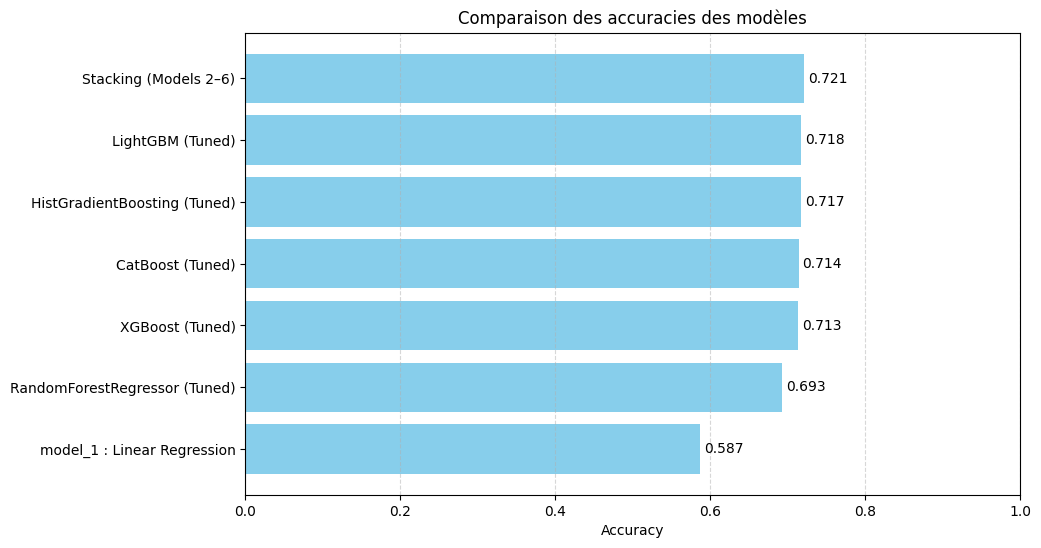

In [53]:
df_results = pd.DataFrame(results).sort_values('r2', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_results['model'], df_results['r2'], color='skyblue')

for bar, acc in zip(bars, df_results['r2']):
    plt.text(
        bar.get_width() + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.3f}",
        va='center'
    )

plt.xlabel('Accuracy')
plt.title('Comparaison des accuracies des modèles')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [54]:
for model, acc in df_results[['model', 'r2']].values:
    print(f"{model} : R² = {acc:.3f}")

Stacking (Models 2–6) : R² = 0.721
LightGBM (Tuned) : R² = 0.718
HistGradientBoosting (Tuned) : R² = 0.717
CatBoost (Tuned) : R² = 0.714
XGBoost (Tuned) : R² = 0.713
RandomForestRegressor (Tuned) : R² = 0.693
model_1 : Linear Regression : R² = 0.587


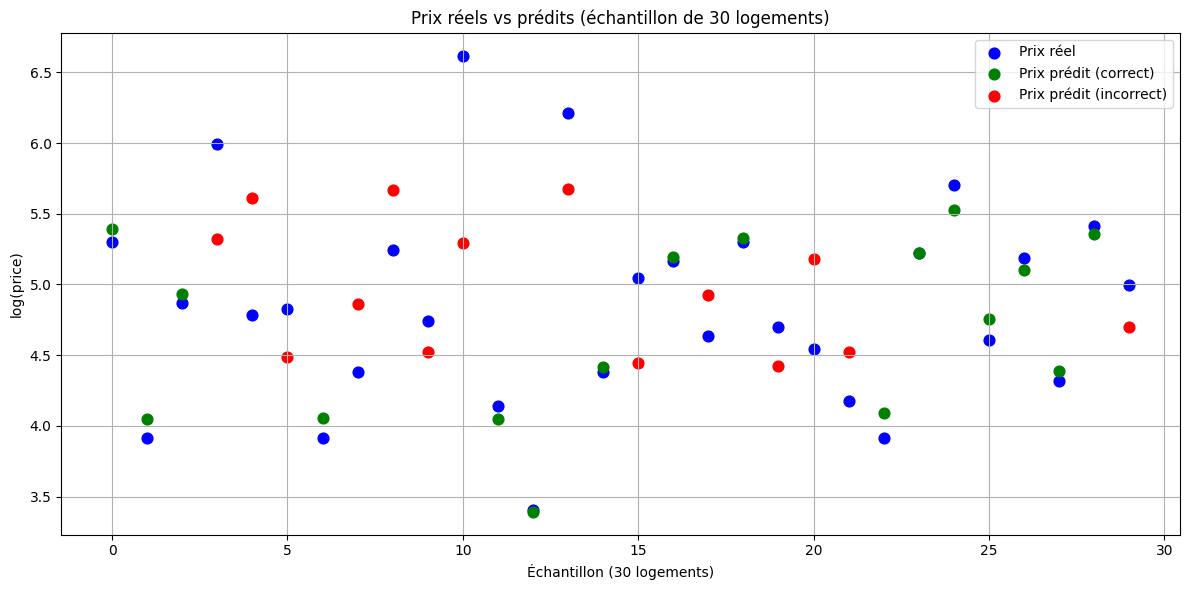

In [60]:
# Convertir y_test en DataFrame pour échantillonnage synchronisé
sample_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': stacking_model.predict(X_test)
})

# Tirer un échantillon aléatoire de 30 lignes
sample = sample_df.sample(n=30, random_state=0).reset_index(drop=True)

# Calcul de l'erreur absolue
sample['abs_error'] = np.abs(sample['y_true'] - sample['y_pred'])

# Masques
well_predicted = sample['abs_error'] < 0.2
poorly_predicted = ~well_predicted

# Tracer
plt.figure(figsize=(12, 6))

# 🔵 Prix réels
plt.scatter(sample.index, sample['y_true'], color='blue', label='Prix réel', s=60)

# 🟢 Bien prédits
plt.scatter(sample.index[well_predicted], sample['y_pred'][well_predicted],
            color='green', label='Prix prédit (correct)', s=60)

# 🔴 Mal prédits
plt.scatter(sample.index[poorly_predicted], sample['y_pred'][poorly_predicted],
            color='red', label='Prix prédit (incorrect)', s=60)

# Mise en forme
plt.xlabel('Échantillon (30 logements)')
plt.ylabel('log(price)')
plt.title('Prix réels vs prédits (échantillon de 30 logements)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()